In [62]:
import collections
from pathlib import Path
import json
import cv2 as cv
import matplotlib.pyplot as plt

import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn

from utils import load_obj_tsv
from dataset.vqa import VQADataset,VQATorchDataset, VQAEvaluator

from models.lxrt_adaptive import Model_Args

In [2]:
home = str(Path.home())
MSCOCO_IMGFEAT_ROOT = home + '/data/mscoco_imgfeat/'
VQA_DATA_ROOT = home+'/data/vqa/'
load_lxmert_qa_path = home+'/snap/pretrained/model'

In [3]:
class Args():
    def __init__(self):
        self.tiny = True
        self.bs = 1

In [4]:
args = Args()

In [5]:
DataTuple = collections.namedtuple("DataTuple", 'dataset loader evaluator')

def get_data_tuple(path: str, mscoco_path: str, splits: str, tiny: bool,bs:int, shuffle=False, drop_last=False) -> DataTuple:
    dset = VQADataset(path,splits)
    tset = VQATorchDataset(dset,mscoco_path,tiny)
    evaluator = VQAEvaluator(dset)
    pin_memory = True if torch.cuda.is_available() else False
    data_loader = DataLoader(
        tset, batch_size=bs,
        shuffle=shuffle, num_workers=1,
        drop_last=drop_last, pin_memory=pin_memory
    )

    return DataTuple(dataset=dset,loader=data_loader, evaluator=evaluator)

train_tuple = get_data_tuple(VQA_DATA_ROOT, MSCOCO_IMGFEAT_ROOT, 'train,nominival', args.tiny, args.bs,True,True)
valid_tuple = get_data_tuple(VQA_DATA_ROOT, MSCOCO_IMGFEAT_ROOT,'minival',args.tiny,args.bs,True,True)

0it [00:00, ?it/s]

Load 632117 data from split(s) train,nominival.
Start to load Faster-RCNN detected objects from /home/u37216/data/mscoco_imgfeat/train2014_obj36.tsv


492it [00:02, 179.64it/s]
19it [00:00, 189.17it/s]

Loaded 500 images in file /home/u37216/data/mscoco_imgfeat/train2014_obj36.tsv in 2 seconds.
Start to load Faster-RCNN detected objects from /home/u37216/data/mscoco_imgfeat/val2014_obj36.tsv


494it [00:02, 181.34it/s]


Loaded 500 images in file /home/u37216/data/mscoco_imgfeat/val2014_obj36.tsv in 2 seconds.
Use 2810 data in torch dataset



17it [00:00, 165.06it/s]

Load 25994 data from split(s) minival.
Start to load Faster-RCNN detected objects from /home/u37216/data/mscoco_imgfeat/val2014_obj36.tsv


492it [00:02, 180.16it/s]

Loaded 500 images in file /home/u37216/data/mscoco_imgfeat/val2014_obj36.tsv in 2 seconds.
Use 2546 data in torch dataset



In [30]:
dset = VQADataset(VQA_DATA_ROOT,'train,nominival')
tset = VQATorchDataset(dset,MSCOCO_IMGFEAT_ROOT,tiny=True)

Load 632117 data from split(s) train,nominival.


19it [00:00, 188.31it/s]

Start to load Faster-RCNN detected objects from /home/u37216/data/mscoco_imgfeat/train2014_obj36.tsv


494it [00:02, 181.57it/s]
19it [00:00, 189.76it/s]

Loaded 500 images in file /home/u37216/data/mscoco_imgfeat/train2014_obj36.tsv in 2 seconds.
Start to load Faster-RCNN detected objects from /home/u37216/data/mscoco_imgfeat/val2014_obj36.tsv


485it [00:02, 177.74it/s]


Loaded 500 images in file /home/u37216/data/mscoco_imgfeat/val2014_obj36.tsv in 2 seconds.
Use 2810 data in torch dataset



In [6]:
from models.lxrt_adaptive import VQAModel_Adaptive
#from tasks.vqa_model import VQAModel

In [7]:
model_args = Model_Args(9,6,6)
model_args.sparse = False #args.sparse

In [8]:
adapt_span_params = {'adapt_span_enabled': True, 'attn_span': 1024, 'adapt_span_loss_coeff': 0.000005,
                     'adapt_span_ramp': 32, 'adapt_span_init': 0.6, 'adapt_span_cache': True, 
                     'nb_heads': 12,'bs': args.bs, 'mask_size': [20,36]}

In [9]:
model = VQAModel_Adaptive(train_tuple[0].num_answers,model_args,adapt_span_params)
#model = VQAModel(train_tuple[0].num_answers,model_args)

I0126 00:01:30.595081 139641397345152 tokenization_utils.py:398] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/u37216/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
I0126 00:01:30.941034 139641397345152 modeling.py:776] loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /home/u37216/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
I0126 00:01:30.944420 139641397345152 modeling.py:784] extracting archive file /home/u37216/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /home/u37216/tmp/tmpe3nn1zhr
I0126 00:01:38.033662 13964139734515

LXRT encoder with 9 l_layers, 6 x_layers, and 6 r_layers.
Using adaptive variant


In [74]:
ques_id,feats,boxes,sent,target = next(iter(train_tuple[1]))

Traceback (most recent call last):
  File "/glob/intel-python/python3/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/glob/intel-python/python3/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/glob/intel-python/python3/lib/python3.6/shutil.py", line 480, in rmtree
    _rmtree_safe_fd(fd, path, onerror)
  File "/glob/intel-python/python3/lib/python3.6/shutil.py", line 438, in _rmtree_safe_fd
    onerror(os.unlink, fullname, sys.exc_info())
  File "/glob/intel-python/python3/lib/python3.6/shutil.py", line 436, in _rmtree_safe_fd
    os.unlink(name, dir_fd=topfd)
OSError: [Errno 16] Device or resource busy: '.nfs0000002b800a7a1d000006fe'


In [75]:
logit = model(feats,boxes,sent)

In [76]:
score, label = logit.max(1)

In [77]:
score

tensor([2.4868], grad_fn=<MaxBackward0>)

In [78]:
label

tensor([930])

In [79]:
dset = train_tuple[0]

In [80]:
for qid, l in zip(ques_id, label.cpu().numpy()):
    print(qid,l)

tensor(394480020) 930


In [81]:
quesid2ans = {}
for qid, l in zip(ques_id, label.cpu().numpy()):
    ans = dset.label2ans[l]
    quesid2ans[qid.item()] = ans

In [82]:
ans

'mariners'

In [83]:
qid.item()

394480020

In [86]:
splits = 'train,nominival'
path = VQA_DATA_ROOT
splits = splits.split(',')

In [87]:
data = []
for split in splits:
    data.extend(json.load(open(path+"%s.json" % split)))

In [88]:
main_idx = 0
for idx,i in enumerate(data):
    if i['question_id']==qid.item():
        print(idx)
        main_idx = idx

273582


In [89]:
data[main_idx]

{'answer_type': 'yes/no',
 'img_id': 'COCO_train2014_000000394480',
 'label': {'no': 1, 'yes': 1},
 'question_id': 394480020,
 'question_type': 'is it',
 'sent': 'Is it a chilly day?'}

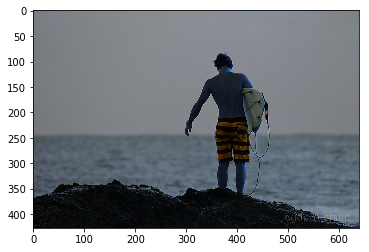

In [90]:
im = cv.imread(VQA_DATA_ROOT+'train'+'2014'+'/'+ data[main_idx]['img_id']+'.jpg')
im = plt.imshow(im)
im = plt.show()